In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from collections import Counter
from sklearn.preprocessing import StandardScaler
import os
import xgboost as xgb
from sklearn import model_selection
import ast
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

## Анализ данных

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
#Посмотрим на исходные данные
print(train.shape)
print(test.shape)
train.head()

(3000, 23)
(4398, 22)


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [5]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

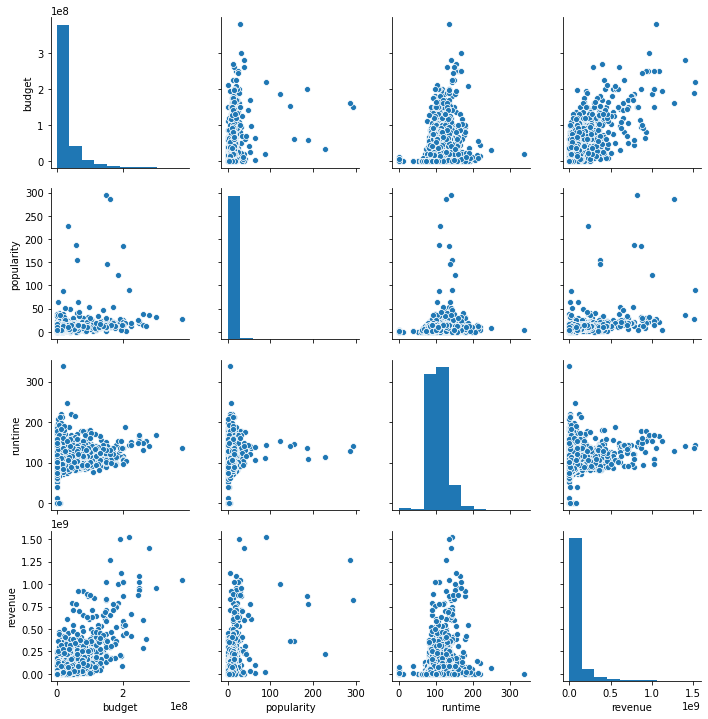

In [6]:
#Посмотрим на зависимость некоторых признаков и целевой переменной, как она распределена
features = ['budget', 'popularity', 'runtime', 'revenue']
sns.pairplot(train[features])

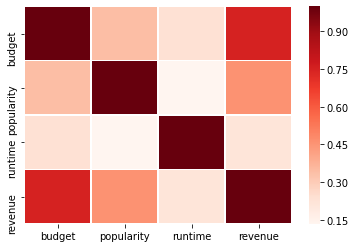

In [7]:
#построим матрицу корреляции
sns.heatmap(train[features].corr(), linewidths=.5, cmap="Reds")

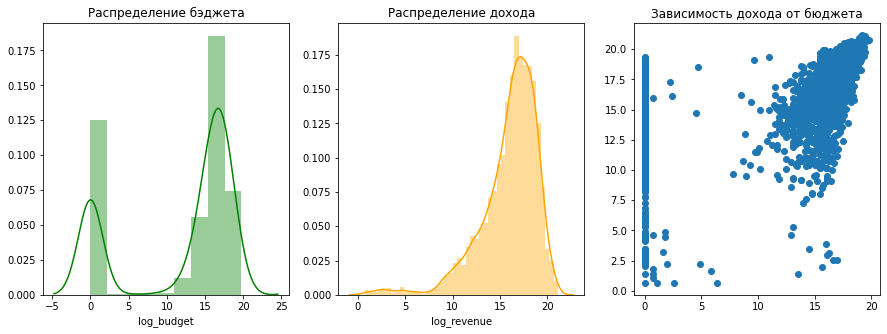

In [8]:
#от признаков в денежном выражении возьмем логарифм
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

train['log_revenue'] = np.log1p(train['revenue'])

fig, ax = plt.subplots(figsize = (15, 5))
plt.subplot(1, 3, 1)
plt.title('Распределение бджета')
sns.distplot(train['log_budget'], color='Green');
plt.subplot(1, 3, 2)
plt.title('Распределение дохода')
sns.distplot(train['log_revenue'], color='Orange');
plt.subplot(1, 3, 3)
plt.title('Зависимость дохода от бюджета')
plt.scatter(train['log_budget'], train['log_revenue'])


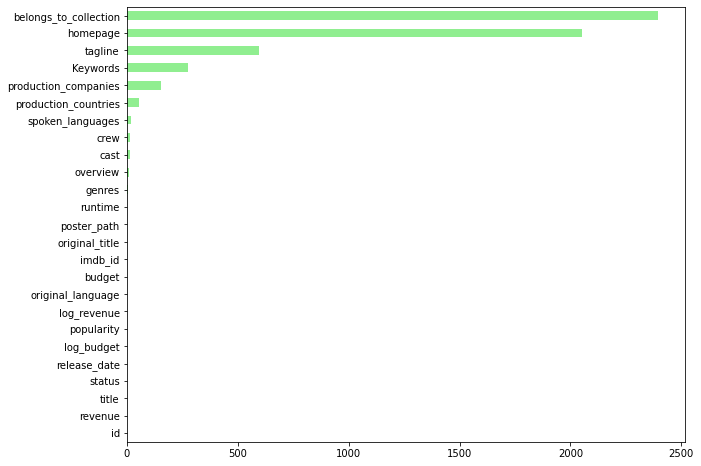

In [9]:
#Видим, что многие признаки содержат большое количество пустых значений
fig = plt.figure(figsize=(10, 8))
train.isna().sum().sort_values(ascending=True).plot(kind='barh',colors='LightGreen')

## Подготовка признаков

In [10]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,log_budget,log_revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,16.454568,16.326300
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,17.504390,18.370959
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,15.009433,16.387512
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,13.997833,16.588099
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,0.000000,15.182615


In [11]:
#Попробуем из данных, представленных в виде json выделить важные составляющие

#функция преобразования дат, т.к. у всех только две последние цифры
def fix_date(x):
    year = x.split('/')[2]
    if int(year) <= 19:
        return x[:-2] + '20' + year
    else:
        return x[:-2] + '19' + year

df = pd.concat([train, test]).reset_index(drop = True)
print('All data shape')
print(df.shape)

json_features=["belongs_to_collection", "genres", "production_companies", "production_countries", "spoken_languages"]

for feature in json_features:
    df.loc[df[feature].notnull(),feature]=df.loc[df[feature].notnull(),feature].apply(lambda x : ast.literal_eval(x)).apply(lambda x : [y["name"] for y in x])

df["in_collection"]=1
df.loc[df["belongs_to_collection"].isnull(),"in_collection"]=0
df["genres_len"]=df.loc[df["genres"].notnull(),"genres"].apply(lambda x : len(x))
df["production_companies_len"]=df.loc[df["production_companies"].notnull(),"production_companies"].apply(lambda x : len(x))
df["production_countries_len"]=df.loc[df["production_countries"].notnull(),"production_countries"].apply(lambda x : len(x))
df["spoken_languages_len"]=df.loc[df["spoken_languages"].notnull(),"spoken_languages"].apply(lambda x : len(x))

df.loc[df["cast"].notnull(),"cast"]=df.loc[df["cast"].notnull(),"cast"].apply(lambda x : ast.literal_eval(x))
df.loc[df["crew"].notnull(),"crew"]=df.loc[df["crew"].notnull(),"crew"].apply(lambda x : ast.literal_eval(x))
df["cast_len"] = df.loc[df["cast"].notnull(),"cast"].apply(lambda x : len(x))
df["crew_len"] = df.loc[df["crew"].notnull(),"crew"].apply(lambda x : len(x))

df.loc[df["homepage"].notnull(),"homepage"]=1
df["homepage"]=df["homepage"].fillna(0)

df["has_tagline"]=1
df.loc[df["tagline"].isnull(),"has_tagline"]=0

df["title_different"]=1
df.loc[df["title"]==df["original_title"],"title_different"]=0

df.loc[df["release_date"].notnull(),"release_date"]=df.loc[df["release_date"].notnull(),"release_date"].apply(lambda x : fix_date(x))
release_date=pd.to_datetime(df["release_date"])
df["release_year"]=release_date.dt.year
df["release_month"]=release_date.dt.month
df["release_day"]=release_date.dt.day
df["release_wd"]=release_date.dt.dayofweek
df["release_quarter"]=release_date.dt.quarter

#кодируем строковый атрибут как число
encoder = LabelEncoder()
encoder.fit(list(df['original_language'].fillna('')))
df['original_language'] = encoder.transform(df['original_language'].fillna('').astype(str))

df['log_popularity']=np.log1p(df['popularity'])

#заполним пропуски
df.fillna(value=0.0, inplace = True)

train = df.loc[:train.shape[0] - 1,:]
test = df.loc[train.shape[0]:,:]
print(train.shape)
print(test.shape)

All data shape
(7398, 25)
(3000, 40)
(4398, 40)


In [12]:
train.head()

,Keywords,belongs_to_collection,budget,cast,crew,genres,homepage,id,imdb_id,log_budget,...,cast_len,crew_len,has_tagline,title_different,release_year,release_month,release_day,release_wd,release_quarter,log_popularity
0,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...",[Hot Tub Time Machine Collection],14000000,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",[Comedy],0,1,tt2637294,16.454568,...,24.0,72.0,1,0,2015.0,2.0,20.0,4.0,1.0,2.024905
1,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...",[The Princess Diaries Collection],40000000,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...","[Comedy, Drama, Family, Romance]",0,2,tt0368933,17.504390,...,20.0,9.0,1,0,2004.0,8.0,6.0,4.0,3.0,2.224504
2,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...",0,3300000,"[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",[Drama],1,3,tt2582802,15.009433,...,51.0,64.0,1,0,2014.0,10.0,10.0,4.0,4.0,4.178992
3,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...",0,1200000,"[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...","[Thriller, Drama]",1,4,tt1821480,13.997833,...,7.0,3.0,0,0,2012.0,3.0,9.0,4.0,1.0,1.429099
4,0,0,0,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...","[Action, Thriller]",0,5,tt1380152,0.000000,...,4.0,2.0,0,1,2009.0,2.0,5.0,3.0,1.0,0.764570


In [13]:
#Таким образом, скорее всего признаки, где большая часть данных пустая не повлияют на результат - удалим их
#Также видим, что есть очевидные бесполезные признаки, как например imdb_id или status
useless_features = ['belongs_to_collection', 'homepage', 'tagline', 
                    'Keywords', 'id', 'imdb_id', 'status', 'poster_path', 
                    'title', 'original_title', 'genres', 'production_companies', 
                    'production_countries', 'spoken_languages', 'cast', 
                    'crew', 'release_date', 'overview', 'budget', 'popularity']
train = train.drop(useless_features, axis=1)
train = train.drop('revenue', axis=1)
test = test.drop(useless_features + ['revenue', 'log_revenue'], axis=1)
print(train.shape)
print(test.shape)

(3000, 19)
(4398, 18)


In [14]:
train.head()

,log_budget,log_revenue,original_language,runtime,in_collection,genres_len,production_companies_len,production_countries_len,spoken_languages_len,cast_len,crew_len,has_tagline,title_different,release_year,release_month,release_day,release_wd,release_quarter,log_popularity
0,16.454568,16.326300,10,93.0,1,1.0,3.0,1.0,1.0,24.0,72.0,1,0,2015.0,2.0,20.0,4.0,1.0,2.024905
1,17.504390,18.370959,10,113.0,1,4.0,1.0,1.0,1.0,20.0,9.0,1,0,2004.0,8.0,6.0,4.0,3.0,2.224504
2,15.009433,16.387512,10,105.0,0,1.0,3.0,1.0,1.0,51.0,64.0,1,0,2014.0,10.0,10.0,4.0,4.0,4.178992
3,13.997833,16.588099,16,122.0,0,2.0,0.0,1.0,2.0,7.0,3.0,0,0,2012.0,3.0,9.0,4.0,1.0,1.429099
4,0.000000,15.182615,24,118.0,0,2.0,0.0,1.0,1.0,4.0,2.0,0,1,2009.0,2.0,5.0,3.0,1.0,0.764570


In [15]:
test.head()

,log_budget,original_language,runtime,in_collection,genres_len,production_companies_len,production_countries_len,spoken_languages_len,cast_len,crew_len,has_tagline,title_different,release_year,release_month,release_day,release_wd,release_quarter,log_popularity
3000,0.000000,21,90.0,1,4.0,0.0,2.0,2.0,7.0,2.0,1,1,2007.0,7.0,14.0,5.0,3.0,1.579295
3001,11.385103,10,65.0,0,2.0,1.0,1.0,1.0,10.0,8.0,1,0,1958.0,5.0,19.0,0.0,2.0,1.517276
3002,0.000000,10,100.0,0,2.0,3.0,1.0,1.0,9.0,10.0,1,0,1997.0,5.0,23.0,4.0,2.0,2.206646
3003,15.732433,14,130.0,0,3.0,3.0,2.0,3.0,23.0,69.0,1,0,2010.0,9.0,4.0,5.0,3.0,2.261348
3004,14.508658,10,92.0,0,2.0,0.0,1.0,1.0,4.0,14.0,1,0,2005.0,2.0,11.0,4.0,1.0,1.439285


In [16]:
#сформируем выборку данных для обучения модели
X = train.drop(['log_revenue'], axis=1)
y = train['log_revenue']

In [17]:
print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12, shuffle=False)
print('Train data shape')
print(X_train.shape)
print('Test data shape')
print(X_test.shape)

(3000, 18)
(3000,)
Train data shape
(2700, 18)
Test data shape
(300, 18)


## Обучение модели и валидация

In [18]:
def rmsle(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

def predict(model):
    model.fit(X_train.values, y_train)
    y_pred = model.predict(X_test.values)
    print(rmsle(y_test, y_pred))
    return y_pred
    
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
    return(rmse)

def eval_model(model, name):
    start_time = time.time()
    score = rmsle_cv(model)
    print("{} score: {:.4f} ({:.4f}),     execution time: {:.1f}".format(name, score.mean(), score.std(), time.time()-start_time))

In [19]:
mod_xgb = xgb.XGBRegressor(objective  = 'reg:linear', 
          eta = 0.01, 
          max_depth = 6,
          min_child_weight = 3,
          subsample = 0.8, 
          colsample_bytree = 0.8,
          colsample_bylevel = 0.50, 
          gamma = 0.1, 
          eval_metric = 'rmse',
          seed = 12, n_estimators = 2000)
eval_model(mod_xgb, "xgb")

[17:04:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[17:04:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
xgb score: 2.1477 (0.0760),     execution time: 31.8


In [20]:
train_pred = predict(mod_xgb)

[17:04:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
1.8621571027640722


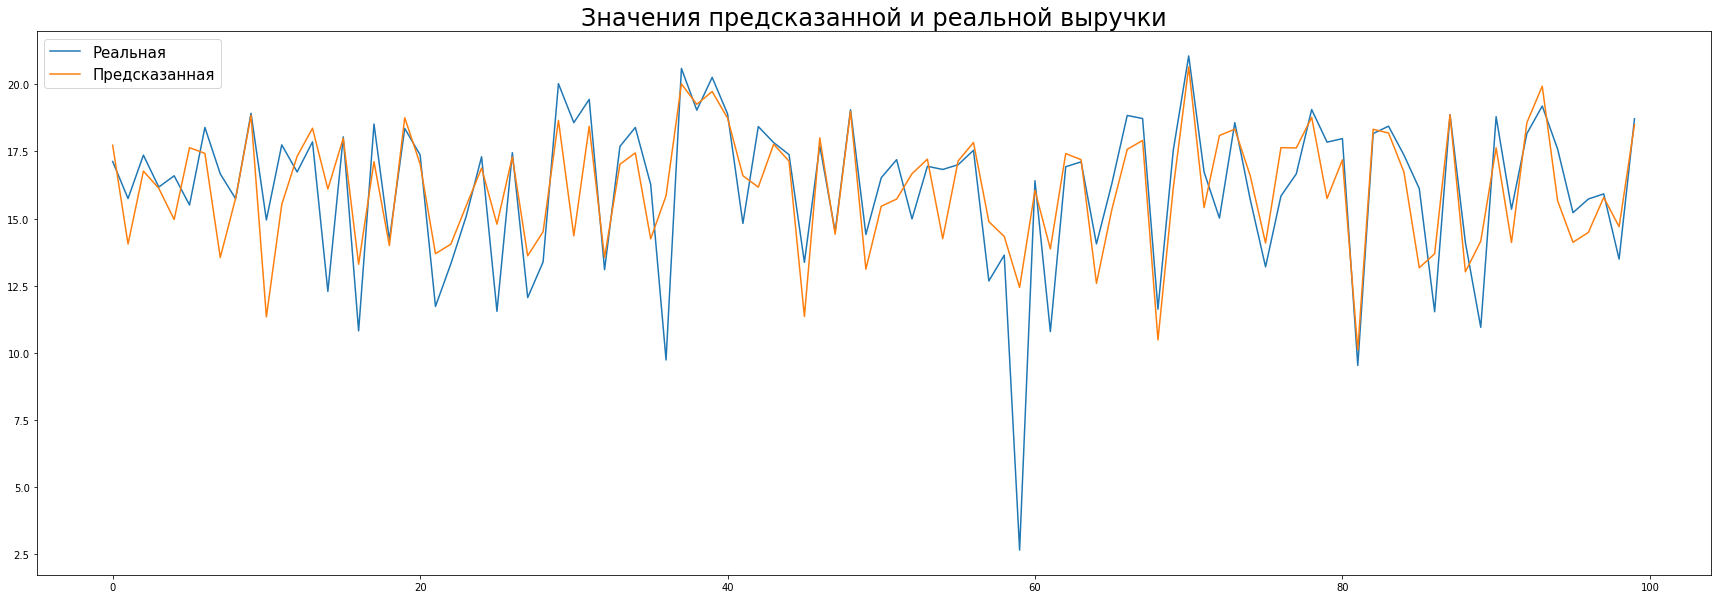

In [21]:
plt.figure(figsize=(30,10))
plt.plot(np.array(y_test[:100]),label="Реальная")
plt.plot(train_pred[:100],label="Предсказанная")
plt.legend(fontsize=15)
plt.title("Значения предсказанной и реальной выручки",fontsize=24)
plt.show()

In [22]:
#Пройдемся еще раз алгоритмом XGBoost с использованием интерфейса враппера
params = {'objective': 'reg:linear', 
          'eta': 0.01, 
          'max_depth': 6, 
          'min_child_weight': 3,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'colsample_bylevel': 0.50, 
          'gamma': 0.1, 
          'eval_metric': 'rmse', 
          'seed': 12, 
          'silent': True    
}
xgb_data = [(xgb.DMatrix(X_train, y_train), 'train'), (xgb.DMatrix(X_test, y_test), 'valid')]
mod_xgb_base = xgb.train(params, 
                  xgb.DMatrix(X_train, y_train),
                  5000,  
                  xgb_data, 
                  verbose_eval=200,
                  early_stopping_rounds=200)

[0]	train-rmse:15.60243	valid-rmse:15.66528
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
[200]	train-rmse:2.83074	valid-rmse:2.82810
[400]	train-rmse:1.64616	valid-rmse:1.85866
[600]	train-rmse:1.46127	valid-rmse:1.83219
[800]	train-rmse:1.33105	valid-rmse:1.83582
Stopping. Best iteration:
[669]	train-rmse:1.41561	valid-rmse:1.83087



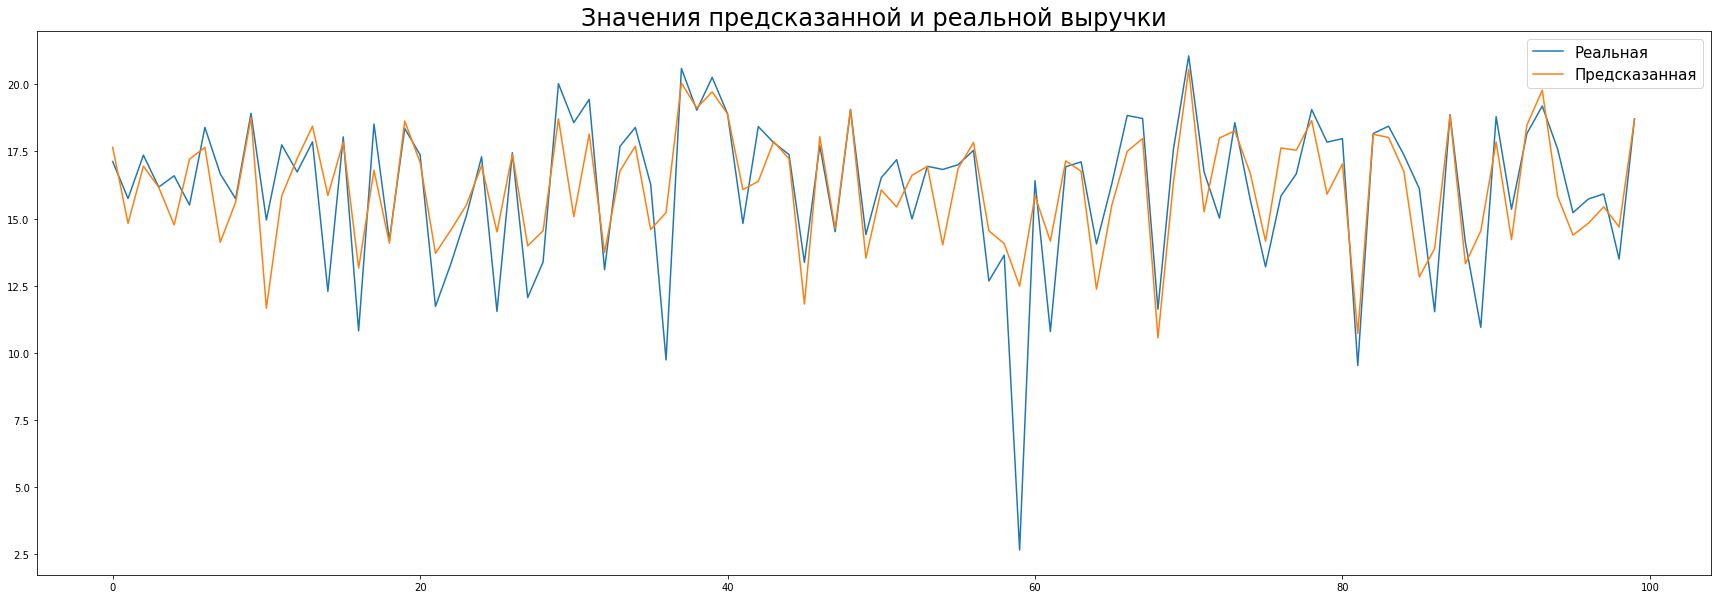

In [23]:
train_pred = mod_xgb_base.predict(xgb.DMatrix(X_test), ntree_limit=mod_xgb_base.best_ntree_limit)
plt.figure(figsize=(30,10))
plt.plot(np.array(y_test[:100]),label="Реальная")
plt.plot(train_pred[:100],label="Предсказанная")
plt.legend(fontsize=15)
plt.title("Значения предсказанной и реальной выручки",fontsize=24)
plt.show()

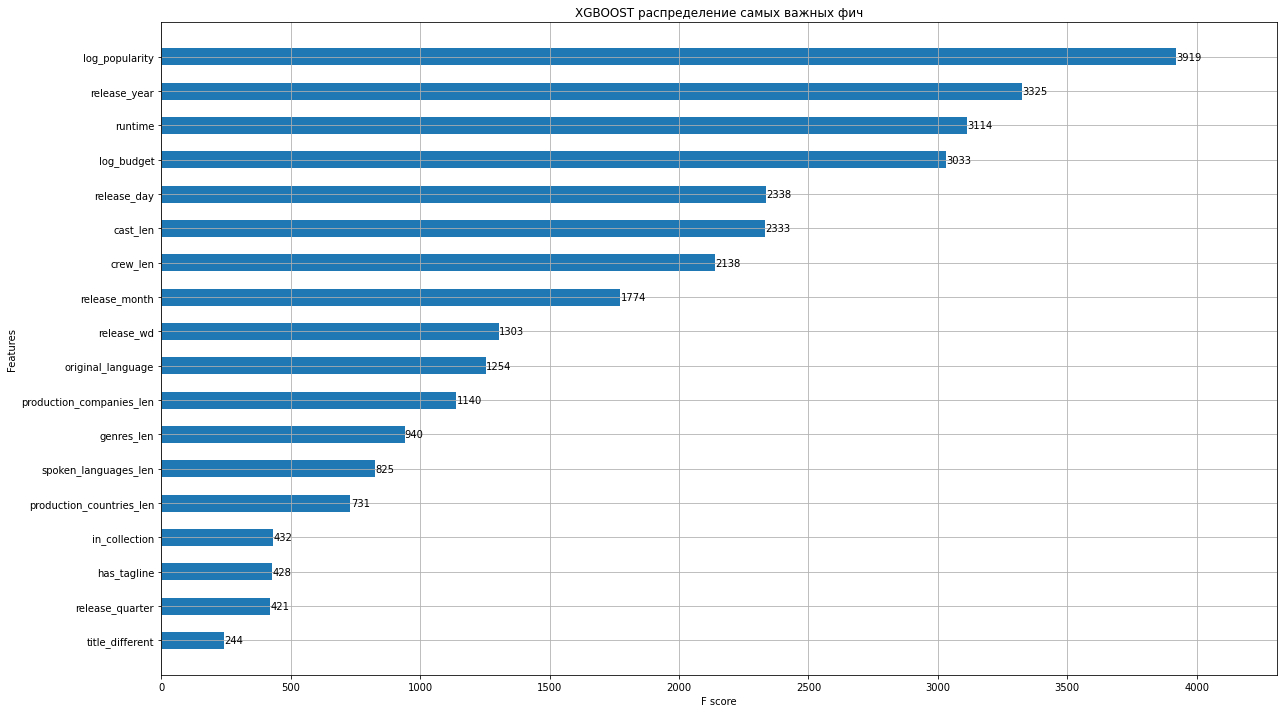

In [24]:
fig, ax = plt.subplots(figsize=(20,12))
xgb.plot_importance(mod_xgb_base, max_num_features=40, height = 0.5, ax = ax)
plt.title('XGBOOST распределение самых важных фич')
plt.show()

Попробуем обучить другую модель

In [25]:
nr_cv = 5
linreg = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear = GridSearchCV(linreg, parameters, cv=nr_cv, verbose=1 , scoring = "neg_mean_squared_error")
grid_linear.fit(X, y)

print(grid_linear.best_params_)
print(grid_linear.best_estimator_)

linreg = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
eval_model(linreg, 'Linear Regression')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'copy_X': True, 'fit_intercept': True, 'normalize': True}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)
Linear Regression score: 2.3706 (0.0698),     execution time: 0.0


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.3s finished


In [26]:
train_pred = predict(linreg)

1.981533065116623


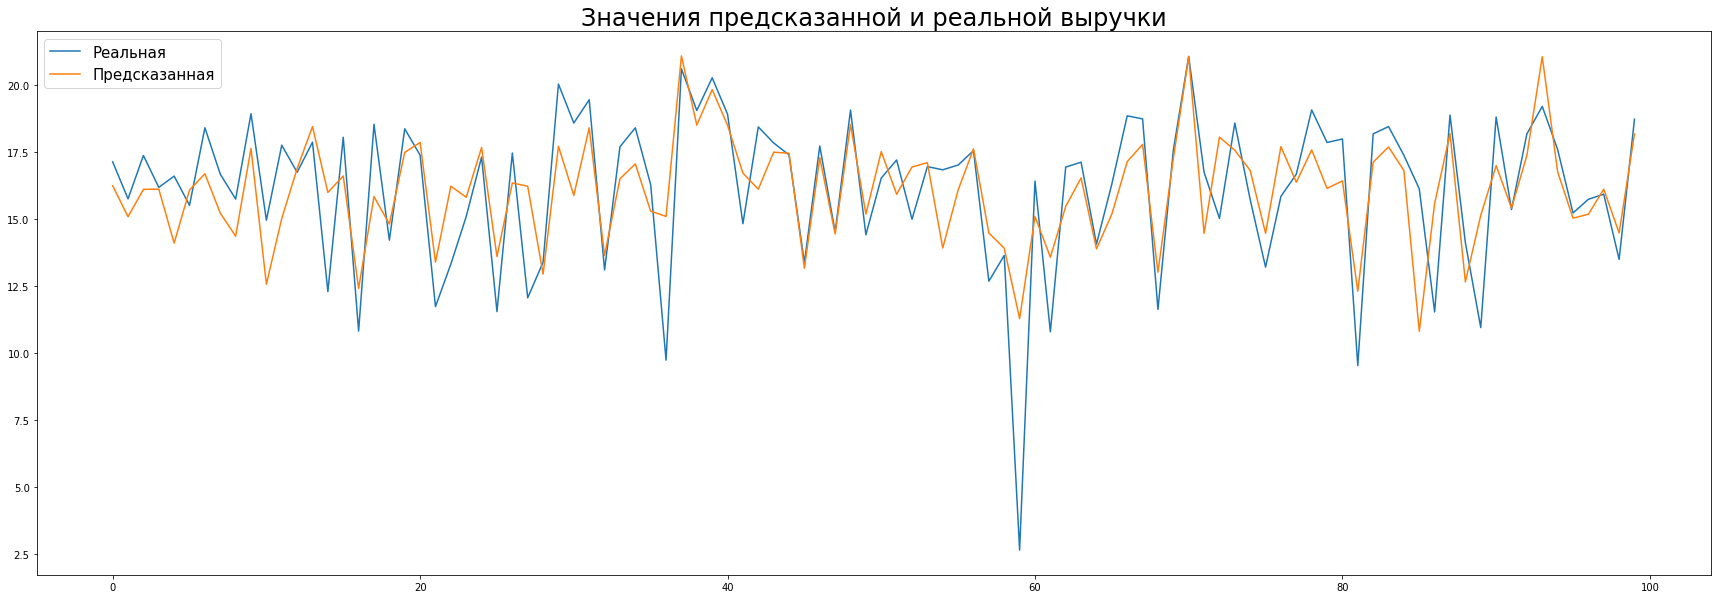

In [27]:
plt.figure(figsize=(30,10))
plt.plot(np.array(y_test[:100]),label="Реальная")
plt.plot(train_pred[:100],label="Предсказанная")
plt.legend(fontsize=15)
plt.title("Значения предсказанной и реальной выручки",fontsize=24)
plt.show()

Графики и score показывают, что алгоритм градиентного бустинга дает меньшую ошибку, но и работает дольше